In [749]:
%store -r Final_Data_Set_Nor
%store -r EN_Des
%store -r Data_Map

import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv
import dgl.nn
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable
from ipykernel import kernelapp as app
import scipy.stats as stats
import pylab as pl
from scipy.stats import norm
import statistics

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter

# Below Function Builds the Graph

In [750]:
def build_borrower_sector_graph(Data_Set):
    
    n_borrowers = len(Data_Set.keys())
    
    sector_list = set()
    for i in Data_Set.items():
        ID,data = i
        sector_list.add(data['Sector'])
    print(sector_list)
    sector_list = list(sector_list)
    n_sectors = len(sector_list)
    
    b_s_dst = []
    for i in Data_Set.items():
        ID,data = i
        b_s_dst.append(sector_list.index(data['Sector']))
    
    b_s_src = T.arange(n_borrowers)
    b_s_dst = T.tensor(b_s_dst)
    
    
    data_dict = {
    ('R&E', 'fin1', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE&TDE', 'fin2', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Description', 'text', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('R', 'R_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('E', 'E_att', 'R&E' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('NDE', 'NDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('TDE', 'TDE_att', 'NDE&TDE' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('Att_Description', 'text_att', 'Description' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('sector', 'belongs to', 'borrower'): (b_s_dst, b_s_src),
    ('Factor', 'effect', 'sector'): (T.tensor([0,1,2]), T.tensor([0,1,2]))
    }

    return dgl.heterograph(data_dict),n_borrowers,n_sectors, b_s_dst

G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Final_Data_Set_Nor)
print("No.of Borrowers ", n_borrowers, " No.of Sectors ", n_sectors)

{'"511210"', '"2111"', '"325412"'}
No.of Borrowers  756  No.of Sectors  3


# This is the Loss Function

'a' in the loss function is the average distance between the embeddings and their respective cluster centroids, whereas 'b' is the average distance between the cluster centroids.

In [858]:
def Loss_Function(embeddings, target_centers, centers, kmeans_labels):
    
    a = T.mean(T.sqrt(T.sum((embeddings - target_centers)**2,1)))
    
    b = 0
    n = 0
    L = np.arange(len(centers))
    for i in range(len(centers)):
        for center in T.index_select(centers, 0, T.tensor(np.delete(L, i, 0))):
            b += T.sum(T.sqrt((T.mean(embeddings[np.where(training_kmeans.labels_ == i)]) - center)**2))
            n += 1
    
    b = b/(2*n)
    
#     print(a,b)

    return (a - b)
    

In [859]:
T.mean(T.sqrt(T.sum((logits['borrower'] - target_centers)**2,1)))
# T.mean(logits['borrower'][np.where(training_kmeans.labels_ == 0)])

tensor(0.0132, grad_fn=<MeanBackward0>)

# This is the Graph Neural Network


In [860]:
class RGCN(nn.Module):
    def __init__(self, in_RE, out_RE, in_NT, out_NT, in_Des, out_Des, in_sector, out_sector, in_borrower, out_borrower, L1_names, L2_names, L3_names, L4_names, L5_names):
        super().__init__()

        self.conv1 = dgl.nn.HeteroGraphConv({rel: SAGEConv(in_sector, out_sector, 'mean',norm = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv2 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_RE, out_RE, 'none', False, activation = None, bias = False) for rel in L2_names}, aggregate='max')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_NT, out_NT, 'none', False, activation = None, bias = False) for rel in L3_names}, aggregate='mean')
        #self.conv4 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_Des, out_Des, 'none', activation = None, bias = False) for rel in L4_names}, aggregate='sum')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower, 'none',bias = False) for rel in L5_names}, aggregate='sum')

    def forward(self, graph, inputs):
#         sector_inputs = {'Factor' : inputs['Factor'], 'sector' : inputs['sector'], 'borrower' : inputs['borrower']}
#         h_sector = self.conv1(graph, sector_inputs)
#         h_sector = {k: F.relu(v) for k, v in h_sector.items()}
#         print("Output", h_sector['sector'])
        
        RE_inputs = {'R' : inputs['R'], 'E' : inputs['E'], 'R&E' : inputs['R&E'], 'borrower' : inputs['borrower']}
        h_RE = self.conv2(graph, RE_inputs)
        #h_RE = {k: F.leaky_relu(v) for k, v in h_RE.items()}
        #print("R", inputs['R'], "E", inputs['E'],"R&E ", h_RE['R&E'])
        
#         NT_inputs = {'NDE' : inputs['NDE'], 'TDE' : inputs['TDE'], 'NDE&TDE' : inputs['NDE&TDE'], 'borrower' : inputs['borrower']}
#         h_NT = self.conv3(graph, NT_inputs)
        #h_NT = {k: F.leaky_relu(v) for k, v in h_NT.items()}
        #print("NDE", inputs['NDE'], "TDE", inputs['TDE'],"NDE&TDE ", h_NT['NDE&TDE'])
        
        #Des_inputs = {'Description' : inputs['Description'], 'Att_Description' : inputs['Att_Description'], 'borrower' : inputs['dummy_borrower']}
        #h_Des = self.conv4(graph, Des_inputs)
        #h_Des = {k: F.leaky_relu(v) for k, v in h_Des.items()}
        #print("Description ", h_Des['Description'])
        
        #borrower_inputs = {'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E'],'sector' : h_sector['sector'], 'NDE&TDE' : h_NT['NDE&TDE'], 'Description' : h_Des['Description']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E'],'sector' : h_sector['sector'], 'NDE&TDE' : h_NT['NDE&TDE']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'sector' : h_sector['sector']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'NDE&TDE' : h_NT['NDE&TDE']}
        borrower_inputs = {'borrower' : inputs['borrower'], 'R&E' : h_RE['R&E']}
        #borrower_inputs = {'borrower' : inputs['borrower'], 'Description' : h_Des['Description']}
        h_borrower = self.conv5(graph, borrower_inputs)
        h_borrower = {k: F.leaky_relu(v) for k, v in h_borrower.items()}
        #print("Borrower Embeddings ", h_borrower)
        
        return h_borrower
    


Initializing the nodes of the graph with input features

In [861]:
model = RGCN(5,5,5,5,768,5,5,5,5,5, ['belongs to','effect'],['R_att','E_att','fin1'],['NDE_att','TDE_att','fin2'],['text_att','text'],['belongs to','text','fin1','fin2'])

for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    E_Att = T.tensor([data['EBITDA']])
    NDE_Att = T.tensor([data['NDE']])
    TDE_Att = T.tensor([data['TDE']])
    Des_Att = T.tensor(data['Description Embedding'])
    break
    
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.cat((R_Att,T.tensor([data['Revenue']])),0)
    E_Att = T.cat((E_Att,T.tensor([data['EBITDA']])),0)
    NDE_Att = T.cat((NDE_Att,T.tensor([data['NDE']])),0)
    TDE_Att = T.cat((TDE_Att,T.tensor([data['TDE']])),0)
    Des_Att = T.cat((Des_Att,T.tensor(data['Description Embedding'])),0)

    
G.nodes['borrower'].data['f'] = T.ones(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['E'].data['f'] = E_Att[1:]
G.nodes['R&E'].data['f'] = T.ones(n_borrowers,5)
G.nodes['NDE'].data['f'] = NDE_Att[1:]
G.nodes['TDE'].data['f'] = TDE_Att[1:]
G.nodes['NDE&TDE'].data['f'] = T.ones(n_borrowers,5)
G.nodes['Att_Description'].data['f'] = Des_Att[1:]
G.nodes['Description'].data['f'] = T.ones(n_borrowers,768)
G.nodes['Factor'].data['f'] = T.ones(n_sectors,5)
G.nodes['sector'].data['f'] = T.tensor([[10.,0.,0.,0.,0.],[0.,0.,10.,0.,0.],[0.,0.,0.,0.,10.]])

# Training the graph using an unsupervised learning technique

Avg Node Cluster Distance of Cluster  0  is  5.8820863
Cluster  0  Center  [-16.37168  -18.282398]
Avg Node Cluster Distance of Cluster  1  is  10.466478
Cluster  1  Center  [17.959448  -3.1627674]
Avg Node Cluster Distance of Cluster  2  is  14.433926
Cluster  2  Center  [-11.158661  10.499625]
1   37.513058
2   29.250307
0   37.513058
2   32.164036
0   29.250307
1   32.164036


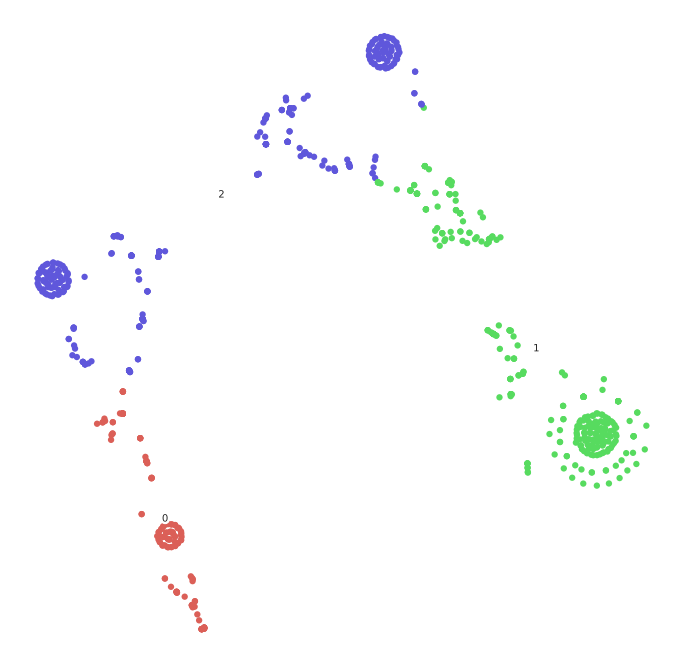

In [862]:
borrower_feats = G.nodes['borrower'].data['f']
sector_feats = G.nodes['sector'].data['f']
R_feats = G.nodes['R'].data['f']
E_feats = G.nodes['E'].data['f']
RE_feats = G.nodes['R&E'].data['f']
NDE_feats = G.nodes['NDE'].data['f']
TDE_feats = G.nodes['TDE'].data['f']
NT_feats = G.nodes['NDE&TDE'].data['f']
Des_feats = G.nodes['Description'].data['f']
Des_att_feats = G.nodes['Att_Description'].data['f']
factor_feats = G.nodes['Factor'].data['f']
dummy_borrower_feats = T.ones(n_borrowers,768)

node_features = {'borrower':borrower_feats,'sector':sector_feats,'R':R_feats,'E':E_feats,'R&E':RE_feats,'NDE':NDE_feats,
                 'Description':Des_feats,'Att_Description':Des_att_feats,'TDE':TDE_feats,'NDE&TDE': NT_feats,
                 'Factor':factor_feats,'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 3
Loss = []
epochs = 100
index = [i for i, n in enumerate(sector_list) if n == 0]
index2 = [i for i, n in enumerate(sector_list) if n == 1]
index3 = [i for i, n in enumerate(sector_list) if n == 2]

    
for epoch in range(epochs):
        
    model.train()                              # Forward Propogation
    logits = model(G, node_features)
    X = logits['borrower'].detach().numpy()

    training_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)    # K_Means Clustering
    centers = training_kmeans.cluster_centers_
    
    if epoch == 0:                                       #TSNE before training
        fashion_tsne = TSNE(random_state=0).fit_transform(X)
        fashion_scatter(fashion_tsne, training_kmeans.labels_)
        
    target_centers = []
    for i in X:
        l = []
        for j in centers:
            mse = np.square(i - j).mean()
            l.append(mse)
        
        target_centers.append(l.index(min(l)))
        
        
    centers = T.tensor(centers)
    target_centers = centers[T.tensor(target_centers)]
    

    score = Loss_Function(logits['borrower'], target_centers, centers, training_kmeans.labels_)     # Loss Calculation
    Loss.append(score.tolist())

    
    opt.zero_grad()             # Back Propogation
    score.backward()
    opt.step()
    


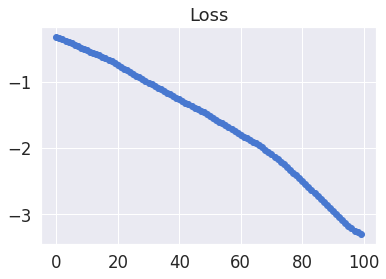

Avg Node Cluster Distance of Cluster  0  is  14.944651
Cluster  0  Center  [-16.060543   7.390794]
Avg Node Cluster Distance of Cluster  1  is  7.8296123
Cluster  1  Center  [23.646498 14.45516 ]
Avg Node Cluster Distance of Cluster  2  is  11.908544
Cluster  2  Center  [  5.6442685 -19.530563 ]
1   40.330563
2   34.58118
0   40.330563
2   38.459198
0   34.58118
1   38.459198


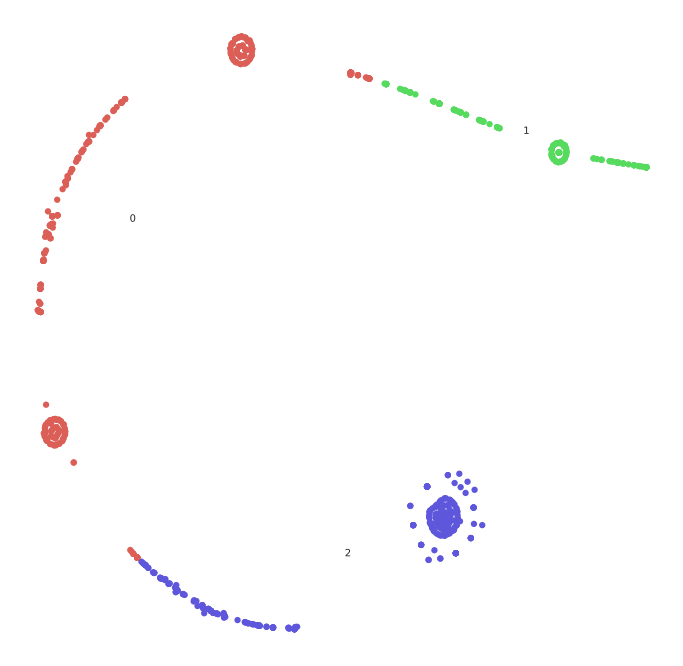

In [863]:
plt.scatter(list(range(len(Loss))),Loss)
plt.title("Loss")
plt.show()


fashion_tsne = TSNE(random_state=0).fit_transform(X)
fashion_scatter(fashion_tsne, training_kmeans.labels_)

# First five elements of each cluster. Here, I'm using only the "Revenue" and "EBITDA" as the inputs to the graph. The below output is the normalized revenue and EBITDA of a borrower using which the graph has clustered the borrowers into three clusters


In [864]:
def Print_Cluster(clusters,kmeans_labels):
    
    for i in range(clusters):

        cluster = np.where(kmeans_labels == i)[0]
        
        N = 0
        if len(cluster) < 5:
            l_N = len(cluster)
        else:
            l_N = 5
            
        n = 0
        print("Cluster ",i, "of size ", len(cluster))
        for i in Final_Data_Set_Nor.items():
            ID,data = i

            if (n in cluster) and (N <= l_N):
                print(data['Revenue'], data['EBITDA'])
                #print(EN_Des[ID]['Description'],"\n")
                N += 1
            elif N > l_N:
                print("\n")
                break
            n += 1

Print_Cluster(clusters,training_kmeans.labels_)

Cluster  0 of size  312
[0.5, 0.5, 0.5, 0.5, 0.5] [0, 0, 0, 0, 0]
[0.5, 0.5, 0.5, 0.4, 0.4] [0.1, 0.3, 0.1, 0, 0]
[0.5, 0.5, 0.7, 0.5, 0.5] [0, 0, 0.6, 0, 0]
[0.5, 0.4, 0.3, 0.2, 0.2] [0, 0, 0, 0, 0]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.1, 0.1]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.2, 0.1]


Cluster  1 of size  176
[0.6, 0.6, 0.6, 0.6, 0.5] [0.5, 0.6, 0.6, 0.5, 0]
[0.7, 0.7, 0.7, 0.7, 0.7] [0.7, 0.6, 0.6, 0.5, 0.5]
[0.7, 0.7, 0.7, 0.7, 0.7] [0.5, 0.5, 0.5, 0.6, 0.6]
[0.9, 0.9, 0.8, 0.8, 0.8] [0.7, 0.7, 0.7, 0.7, 0.7]
[0.6, 0.6, 0.6, 0.5, 0.5] [0.5, 0.5, 0.5, 0.3, 0.3]
[0.7, 0.7, 0.7, 0.7, 0.8] [0.6, 0.6, 0.6, 0.6, 0.6]


Cluster  2 of size  268
[0.1, 0.1, 0.1, 0.1, 0.1] [0.1, 0.1, 0, 0, 0]
[0.2, 0.2, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]
[0.2, 0.4, 0.3, 0.3, 0.1] [0, 0, 0.1, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0.1, 0.1, 0, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0.1, 0, 0, 0]




Borrower Embeddings with respect to clusters 

In [865]:
#Borrower Embeddings of each cluster
for i in range(clusters):
    print("Cluster ", i)
    print(X[np.where(training_kmeans.labels_ == i)[0]][:5],"\n")



Cluster  0
[[ 1.6219423e+00 -3.2261855e-04  2.6782215e+00  2.8188629e+00
   2.4705932e+00]
 [ 1.4933200e+00 -2.2935943e-04  2.4082623e+00  2.5239384e+00
   2.2392640e+00]
 [ 1.7131734e+00 -1.6288452e-04  2.9259634e+00  2.9990263e+00
   2.5892117e+00]
 [ 1.0610770e+00 -2.8639557e-04  1.5443138e+00  1.7083555e+00
   1.5323436e+00]
 [ 9.7316539e-01 -1.9357116e-04  1.6069330e+00  1.6913178e+00
   1.4823561e+00]] 

Cluster  1
[[ 1.8727132e+00 -4.1789262e-04  3.0691266e+00  3.2596231e+00
   2.8364410e+00]
 [ 2.2707191e+00 -4.5166607e-04  3.7495100e+00  3.9464080e+00
   3.4588306e+00]
 [ 2.2707191e+00 -4.5166607e-04  3.7495100e+00  3.9464080e+00
   3.4588306e+00]
 [ 2.7452581e+00 -5.6732126e-04  4.4269686e+00  4.6889467e+00
   4.1564293e+00]
 [ 1.8177085e+00 -2.9388315e-04  2.9439068e+00  3.0877113e+00
   2.7333829e+00]] 

Cluster  2
[[ 3.2438844e-01 -6.4523709e-05  5.3564429e-01  5.6377256e-01
   4.9411863e-01]
 [ 4.7453907e-01 -1.1565531e-04  6.7745852e-01  7.4253899e-01
   6.9759893e-01]
 

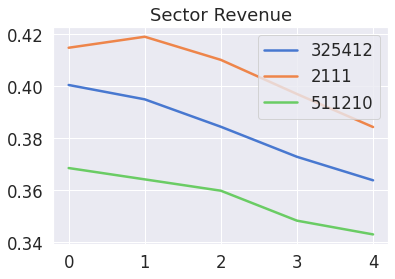

In [850]:
sector_rev_3 = np.array([0.,0.,0.,0.,0.])
sector_rev_2 = np.array([0.,0.,0.,0.,0.])
sector_rev_5 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
for i in Final_Data_Set_Nor.items():
    ID, data = i
    if data['Sector'][1:-1] == "325412":
        sector_rev_3 += np.array(data['Revenue'])
        n += 1
    elif data['Sector'][1:-1] == "2111":
        sector_rev_2 += np.array(data['Revenue'])
        m += 1
    elif data['Sector'][1:-1] == "511210":
        sector_rev_5 += np.array(data['Revenue'])
        p += 1
    
        
sector_rev_3 = sector_rev_3/n
sector_rev_2 = sector_rev_2/m
sector_rev_5 = sector_rev_5/p
p1, = plt.plot(range(len(sector_rev_3)),sector_rev_3)
p2, = plt.plot(range(len(sector_rev_2)),sector_rev_2)
p3, = plt.plot(range(len(sector_rev_5)),sector_rev_5)
plt.legend([p1,p2,p3],['325412', '2111', '511210'])
plt.title("Sector Revenue")
plt.show()

96 115 110


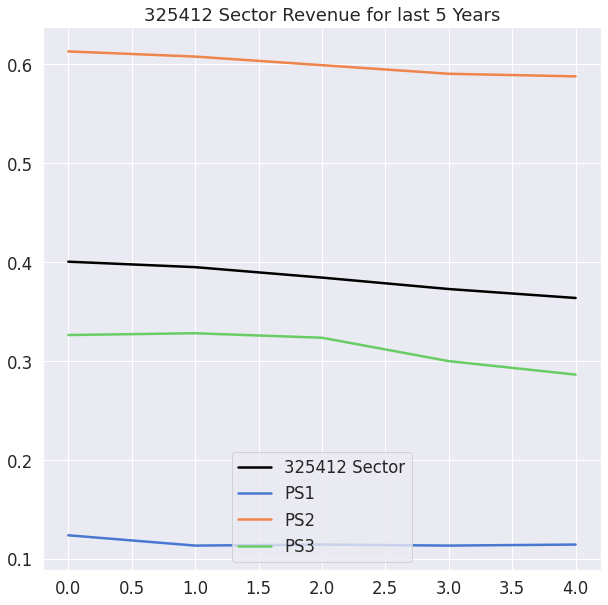

In [844]:
X_1 = logits['borrower'].detach().numpy()[index]
kmeans_1 = KMeans(n_clusters=3, random_state=0).fit(X_1)

PS1_1 = []
PS2_1 = []
PS3_1 = []

for i in list(zip(index,kmeans_1.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_1.append(ind)
    elif ps == 1:
        PS2_1.append(ind)
    elif ps == 2:
        PS3_1.append(ind)
        
Psector1_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_1 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_1 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_1 += np.array(data['Revenue'])
        m += 1
    if n in PS2_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector2_rev_1 += np.array(data['Revenue'])
        p += 1
    if n in PS3_1:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector3_rev_1 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_1 = Psector1_rev_1/m
Psector2_rev_1 = Psector2_rev_1/p
Psector3_rev_1 = Psector3_rev_1/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_3)),sector_rev_3,'k')
ps1, = plt.plot(range(len(Psector1_rev_1)),Psector1_rev_1)
ps2, = plt.plot(range(len(Psector2_rev_1)),Psector2_rev_1)
ps3, = plt.plot(range(len(Psector3_rev_1)),Psector3_rev_1)
plt.legend([S,ps1,ps2,ps3],['325412 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("325412 Sector Revenue for last 5 Years")
plt.show()

# fashion_tsne = TSNE(random_state=123).fit_transform(X_1)
# fashion_scatter(fashion_tsne, kmeans_1.labels_)

59 93 84


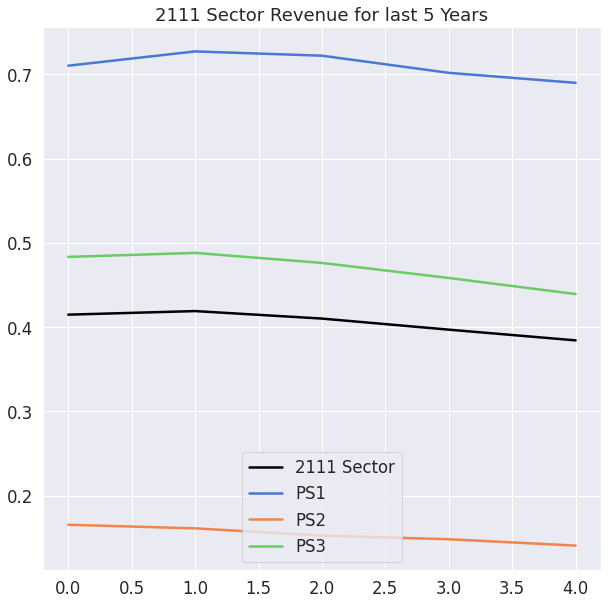

In [845]:
X_2 = logits['borrower'].detach().numpy()[index2]
kmeans_2 = KMeans(n_clusters=3, random_state=0).fit(X_2)

PS1_2 = []
PS2_2 = []
PS3_2 = []

for i in list(zip(index2,kmeans_2.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_2.append(ind)
    elif ps == 1:
        PS2_2.append(ind)
    elif ps == 2:
        PS3_2.append(ind)
        
Psector1_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_2 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_2 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_2:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_2 += np.array(data['Revenue'])
        m += 1
    if n in PS2_2:
        Psector2_rev_2 += np.array(data['Revenue'])
        p += 1
    if n in PS3_2:
        Psector3_rev_2 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_2 = Psector1_rev_2/m
Psector2_rev_2 = Psector2_rev_2/p
Psector3_rev_2 = Psector3_rev_2/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_2)),sector_rev_2,'k')
ps1, = plt.plot(range(len(Psector1_rev_2)),Psector1_rev_2)
ps2, = plt.plot(range(len(Psector2_rev_2)),Psector2_rev_2)
ps3, = plt.plot(range(len(Psector3_rev_2)),Psector3_rev_2)
plt.legend([S,ps1,ps2,ps3],['2111 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("2111 Sector Revenue for last 5 Years")
plt.show()

# fashion_tsne = TSNE(random_state=123).fit_transform(X_2)
# fashion_scatter(fashion_tsne, kmeans_2.labels_)

41 99 59


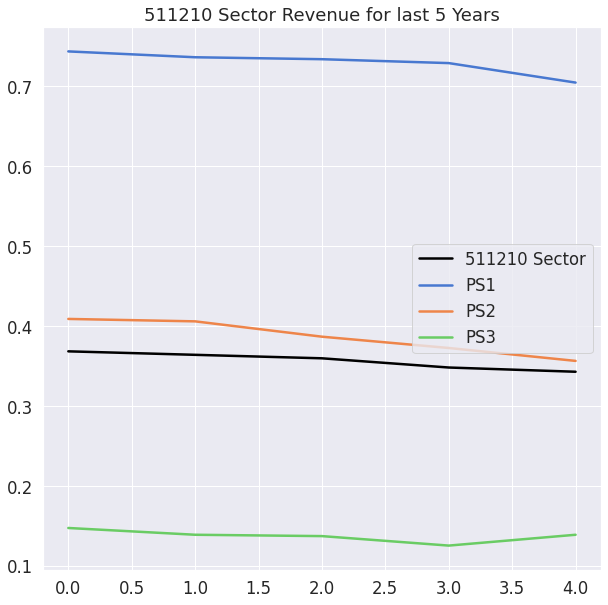

In [846]:
X_3 = logits['borrower'].detach().numpy()[index3]
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(X_3)

PS1_3 = []
PS2_3 = []
PS3_3 = []

for i in list(zip(index3,kmeans_3.labels_)):
    ind,ps = i
    if ps == 0:
        PS1_3.append(ind)
    elif ps == 1:
        PS2_3.append(ind)
    elif ps == 2:
        PS3_3.append(ind)
        
Psector1_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector2_rev_3 = np.array([0.,0.,0.,0.,0.])
Psector3_rev_3 = np.array([0.,0.,0.,0.,0.])
n = 0
m = 0
p = 0
q = 0
for i in Final_Data_Set_Nor.items():
    ID,data = i
    if n in PS1_3:
        #print(data['Sector'],data['Revenue'],data['EBITDA'],data['NDE'],data['TDE'])
        Psector1_rev_3 += np.array(data['Revenue'])
        m += 1
    if n in PS2_3:
        Psector2_rev_3 += np.array(data['Revenue'])
        p += 1
    if n in PS3_3:
        Psector3_rev_3 += np.array(data['Revenue'])
        q += 1
           
    n += 1
    
Psector1_rev_3 = Psector1_rev_3/m
Psector2_rev_3 = Psector2_rev_3/p
Psector3_rev_3 = Psector3_rev_3/q
print(m,p,q)

plt.figure(figsize = (10,10))
S, = plt.plot(range(len(sector_rev_5)),sector_rev_5,'k')
ps1, = plt.plot(range(len(Psector1_rev_3)),Psector1_rev_3)
ps2, = plt.plot(range(len(Psector2_rev_3)),Psector2_rev_3)
ps3, = plt.plot(range(len(Psector3_rev_3)),Psector3_rev_3)
plt.legend([S,ps1,ps2,ps3],['511210 Sector', 'PS1', 'PS2', 'PS3'])
plt.title("511210 Sector Revenue for last 5 Years")
plt.show()

# fashion_tsne = TSNE(random_state=123).fit_transform(X_3)
# fashion_scatter(fashion_tsne, kmeans_3.labels_)

In [762]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(5, 5, bias = False)

    def forward(self, x):
        
        x = self.l1(x)
        
        return x


net = Net()
print(net)

input = T.randn(5)
print(input)
out = net(input)
print(out)

Net(
  (l1): Linear(in_features=5, out_features=5, bias=False)
)
tensor([ 1.3546,  1.8592, -0.9705,  0.7134,  0.6262])
tensor([-0.1060, -0.6962,  0.1811, -0.3081, -0.9515],
       grad_fn=<SqueezeBackward3>)


In [763]:
g = dgl.heterograph({
    ('user', 'follows', 'user') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('user', 'plays', 'game') : (T.tensor([0,1,2]),T.tensor([0,1,2])),
    ('store', 'sells', 'game')  : (T.tensor([0,1,2]),T.tensor([0,1,2]))})

In [764]:
import dgl.nn.pytorch as dglnn
conv = dglnn.HeteroGraphConv({
    'follows' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'plays' : dglnn.GraphConv(3,3, 'none', weight = False, bias = False),
    'sells' : dglnn.SAGEConv(3,3, 'mean', norm = None,weight = False, activation = None, bias = False)}, aggregate='sum')

TypeError: __init__() got an unexpected keyword argument 'weight'

In [ ]:
h1 = {'user' : T.rand(g.number_of_nodes('user'), 3), 'game' : T.ones(g.number_of_nodes('game'), 3)}
h11 = {'store' : T.rand(g.number_of_nodes('store'),3), 'game' : T.zeros(g.number_of_nodes('game'), 3)}
print(h1)
h2 = conv(g, h1)
print(h2)

In [ ]:
    H = {'0':[],'1':[],'2':[]}
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    for n in range(clusters):
        for i in np.where(training_kmeans.labels_ == n)[0]:
            for (j,k) in zip(Final_Data_Set_Nor[Data_Map[i]]['NDE'],Final_Data_Set_Nor[Data_Map[i]]['TDE']):
                H[str(n)].append(max(j,k))
    H['0'].sort()
    H['1'].sort()
    H['2'].sort()
    fit1 = stats.norm.pdf(H['0'], np.mean(H['0']), np.std(H['0'])) 
    fit2 = stats.norm.pdf(H['1'], np.mean(H['1']), np.std(H['1']))
    fit3 = stats.norm.pdf(H['2'], np.mean(H['2']), np.std(H['2']))
    ax1.plot(H['0'],fit1)
    ax2.plot(H['1'],fit2)
    ax3.plot(H['2'],fit3)
    plt.show()

In [ ]:
#     next_target = []
#     for i in range(len(embeddings)):

#         cluster = target_centers[i]
        
#         if len(centers) != 1: 
#             dist = []
#             C = []
#             for m in centers:
#                 d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
#                 dist.append(d)
#                 C.append(m)
                
            
#             tup = list(zip(dist,C))
#             lst = len(tup) 
#             for i in range(0, lst): 

#                 for j in range(0, lst-i-1): 
#                     if (tup[j][0] > tup[j + 1][0]): 
#                         temp = tup[j] 
#                         tup[j]= tup[j + 1] 
#                         tup[j + 1]= temp
            
#             next_c = tup[1][1]
#         else:
#             next_c = centers[0]
            
        
#         next_target.append(next_c.detach().numpy())
    
#     next_target = T.tensor(next_target)
    
    #b = T.sqrt(T.sum((embeddings - next_target)**2,1))